In [1]:
#Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
#Load Dataset
dataset = pd.read_csv('./diabetes.csv')
dataset.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

In [3]:
#Overview of Dataset Characteristics
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
#Summary of N/A Values
dataset.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [5]:
#Distribution of Classes
dataset.Outcome.value_counts()

0    500
1    268
Name: Outcome, dtype: int64

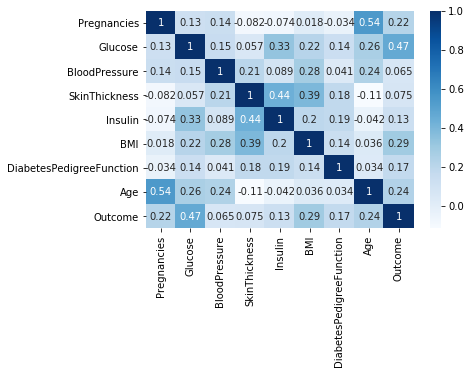

In [7]:
#Review Correlaion between Variables
sns.heatmap(dataset.corr(), annot=True, cmap ="Blues")

In [8]:
#Create X and y Variables
X = dataset.drop('Outcome', axis = 1).values
y = dataset['Outcome'].values

In [13]:
#Prepare for Models for Comparison
#Load Library for Training
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, stratify = y, random_state=100)

SMOTE (Synthetic Minority Over-Sampling Technique)

Creates synthetic samples of the MINORITY class

Selects similar records and alters that record one column at a time by a random amount within difference to neighbouring records

In [19]:
#Fix the Imbalanced Class
from imblearn.over_sampling import SMOTE
smt = SMOTE(random_state = 100)
X_train_smt, y_train_smt = smt.fit_resample(X_train, y_train)

In [20]:
#Import Models
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier

In [22]:
#Construct Some Pipelines
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

pipe_gnb = Pipeline([('scl', StandardScaler()), ('clf', GaussianNB())])
pipe_logreg = Pipeline([('scl', StandardScaler()), ('clf', LogisticRegression(random_state = 100))])
pipe_knn = Pipeline([('scl', StandardScaler()), ('clf', KNeighborsClassifier())])
pipe_sgd = Pipeline([('scl', StandardScaler()), ('clf', SGDClassifier(max_iter=1000, random_state = 100))])

In [24]:
#Set Grid Search params
param_range_k = range(1,10)

param_gridgnb = {}

param_gridlogreg = {'clf__C':[0.01,0.1,1,10,100],
                    'clf__penalty':['l1','l2']}

param_gridknn = {'clf__n_neighbors':param_range_k}

param_gridsgd = {'clf__loss':["hinge","log","perceptron"],
                'clf__alpha':[0.001,0.0001,0.00001]}

In [25]:
#Optimize Models (Note: GNB has no optimizing parameters)
opt_gnb = GridSearchCV(estimator=pipe_gnb, param_grid=param_gridgnb, cv=10, verbose=0, scoring='accuracy',n_jobs=-1)
opt_logreg = GridSearchCV(estimator=pipe_logreg, param_grid=param_gridlogreg, cv=10, verbose=0, scoring='accuracy',n_jobs=-1)
opt_knn = GridSearchCV(estimator=pipe_knn, param_grid=param_gridknn, cv=10, verbose=0, scoring='accuracy',n_jobs=-1)
opt_sgd = GridSearchCV(estimator=pipe_sgd, param_grid=param_gridsgd, cv=10, verbose=0, scoring='accuracy',n_jobs=-1)

In [26]:
#List of Pipelines for ease of iteration
grids = [opt_gnb, opt_logreg, opt_knn, opt_sgd]

In [27]:
#Dictionary of Pipelines and Classifier Types for Ease of reference
grid_dict = {0:'gnb', 1:'LogReg', 2:'kNN', 3:'SGD'}

In [28]:
#Create Table to Compare MLA Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score
pd.set_option('display.max_colwidth',-1)
MLA_columns = []
MLA_compare = pd.DataFrame(columns = MLA_columns)

row_index = 0
for idx, gs in enumerate(grids):
    
    #Fit Grid Search
    gs.fit(X_train_smt, y_train_smt)
    #Predict on test data with best params
    y_pred2 = gs.predict(X_test)
    
    #Create Dataframe to Compare Models
    MLA_compare.loc[row_index, 'Algorithm Name'] = grid_dict[idx]
    MLA_compare.loc[row_index, 'Train Accuracy'] = round(gs.best_score_,2)
    MLA_compare.loc[row_index, 'Precision'] = round(precision_score(y_test, y_pred2, average='weighted'),2)
    MLA_compare.loc[row_index, 'Recall'] = round(recall_score(y_test, y_pred2, average='weighted'),2)
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(gs.best_params_)
    row_index+=1
    
MLA_compare.sort_values(by = ['Precision'], ascending = False, inplace = True)
MLA_compare

C:\Users\iknow\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\iknow\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Algorithm Name  Train Accuracy  Precision  Recall  \
0  gnb            0.71            0.78       0.78     
3  SGD            0.75            0.78       0.78     
1  LogReg         0.75            0.75       0.74     
2  kNN            0.80            0.75       0.74     

                               MLA Parameters  
0  {}                                          
3  {'clf__alpha': 0.0001, 'clf__loss': 'log'}  
1  {'clf__C': 0.1, 'clf__penalty': 'l2'}       
2  {'clf__n_neighbors': 1}

In [29]:
#Prediction Dataset

raw_data = {'Pregnancies':[1],'Glucose':[80], 'BloodPressure':[65], 'SkinThickness':[35], 'Insulin':[80], 'BMI':[24], 
           'DiabetesPedigreeFunction':[0.200], 'Age':[30]}

dfnew = pd.DataFrame(raw_data, columns = 
                    ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI',
                     'DiabetesPedigreeFunction','Age'])
dfnew

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin  BMI  \
0  1            80       65             35             80       24    

   DiabetesPedigreeFunction  Age  
0  0.2                       30

In [30]:
#Prediction
print('Prediction GNB', opt_gnb.predict(dfnew))
print('Prediction LogReg', opt_logreg.predict(dfnew))
print('Prediction kNN', opt_knn.predict(dfnew))
print('Prediction SGD', opt_sgd.predict(dfnew))

Prediction GNB [0]
Prediction LogReg [0]
Prediction kNN [0]
Prediction SGD [0]


C:\Users\iknow\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\iknow\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\iknow\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\iknow\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
